In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage

import io
import xarray as xr

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (40., 40.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
cmip_models = ['MPI-ESM1-2-LR', 'CESM2', 'IPSL-CM6A-LR', 'EC-Earth3', 'CNRM-CM6-1']#, 'EC-Earth3']

In [4]:
experiments = {'historical' : (1980,2007), 'ssp585': (2080,2101), 'amip-lfmip-pdLC_hist' : (1980,2007), 'amip-lfmip-pdLC_fut' : (2080,2101)}

In [159]:
def get_month(mtag, experiments):
    
    struc = {}
    
    pup = 60000
    pdown = 92500
    months = mtag
    
    for exp in experiments:
    
#         exp ='historical'
        tas_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/tas*'+months+'*.nc', concat_dim='model', combine='nested').load()
        uuah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/ua*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=slice(92500,60000)).load()
        uvah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/va*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=slice(92500,60000)).load()
        uah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/ua*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pup).load()
        vah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/va*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pup).load()
        ual_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/ua*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pdown).load()
        val_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/va*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pdown).load()
        sh_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/hfss*'+months+'*.nc', concat_dim='model', combine='nested').load()
        lh_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/hfls*'+months+'*.nc', concat_dim='model', combine='nested').load()
        psl_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/psl*'+months+'*.nc', concat_dim='model', combine='nested').load()
        
        uushear_hist = uuah_hist['ua'].max('plev') - uuah_hist['ua'].min('plev')
        vvshear_hist = uvah_hist['va'].max('plev') - uvah_hist['va'].min('plev')
        maxshear = np.sqrt(uushear_hist**2+vvshear_hist**2)
        
        ef_hist = lh_hist['hfls'] / (lh_hist['hfls']+sh_hist['hfss'])
        prw_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/prw*.nc', concat_dim='model', combine='nested').load()
        
        ushear_hist = uah_hist['ua'] - ual_hist['ua']
        vshear_hist = vah_hist['va'] - val_hist['va']
        
        wsl = np.sqrt(ual_hist['ua']**2+val_hist['va']**2)
        wsh = np.sqrt(uah_hist['ua']**2+vah_hist['va']**2)
        
        grad = np.gradient(tas_hist['tas'])
        grad_ar = tas_hist['tas'].copy(deep=True)
        
        ngrad = grad[1]
        lon, lat = np.meshgrid(grad_ar.lon, grad_ar.lat)
        pos = np.where(lat<0)
        ngrad[:, pos[0], pos[1]] = ngrad[:, pos[0], pos[1]]*-1
        
        grad_ar.values = ngrad
        
        #grad_ar = grad_ar.rename({'tas':'tgrad'})
        
        #ipdb.set_trace()
        
        struc[exp] = {'tas' : tas_hist['tas'],
                      'uah' : uah_hist['ua'],
                      'vah' : vah_hist['va'],
                      'ual' : ual_hist['ua'],
                      'val' : val_hist['va'],
                      'sh' : sh_hist['hfss'],
                      'lh' : lh_hist['hfls'],
                      'ushear' : ushear_hist,
                      'vshear' : vshear_hist,
                      'shear' : maxshear,
                      'ef' : ef_hist,
                      'slp' : psl_hist['psl'],
                      'wsl' : wsl,
                      'wsh' : wsh,
                      'tgrad' : grad_ar,
                      'prw' : prw_hist['prw']}
        
    return struc

In [160]:
DJF_struc = get_month('DJF', experiments)
JJA_struc = get_month('JJA', experiments)

In [233]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


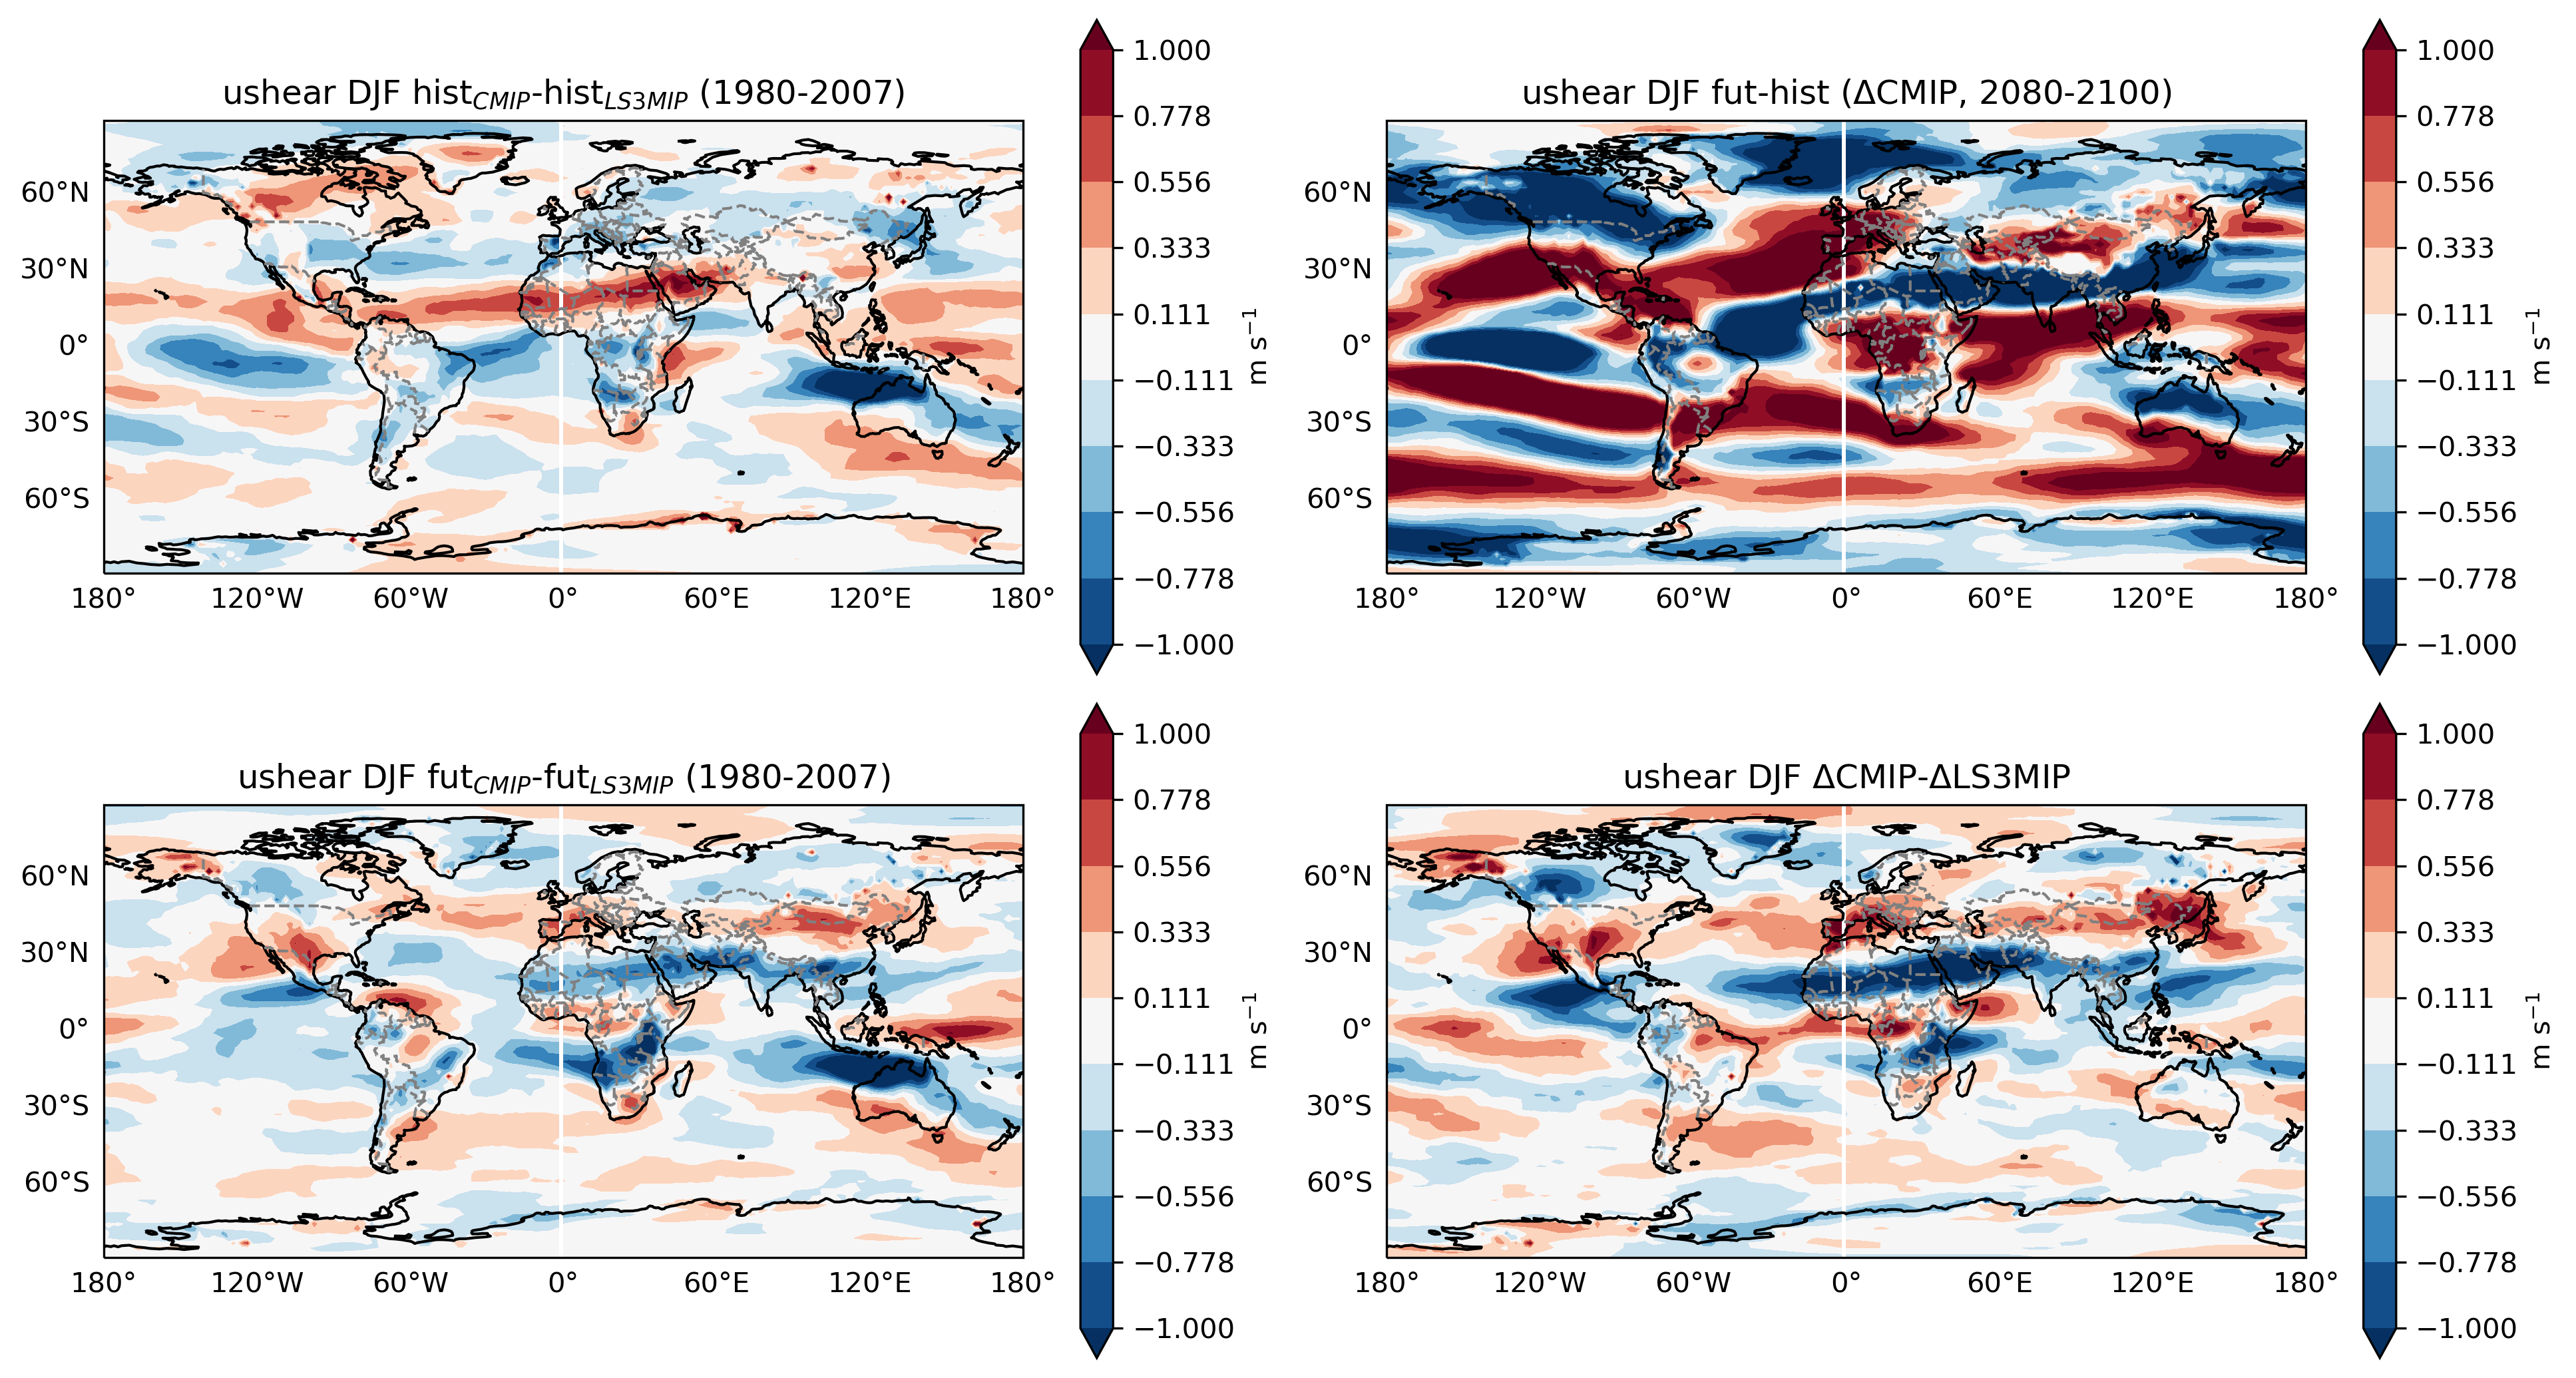

In [187]:
VAR='ushear'
f = plt.figure(figsize=(13,7), dpi=300)
ename = list(experiments.keys())
mtag = 'DJF'
if mtag == 'DJF':
    instruc = DJF_struc
if mtag == 'JJA':
    instruc = JJA_struc

hist = (instruc[ename[0]][VAR]).mean('model')
fut = (instruc[ename[1]][VAR]).mean('model')
ahist = (instruc[ename[2]][VAR]).mean('model')
afut = (instruc[ename[3]][VAR]).mean('model')

diffhist = hist-ahist
diff = fut-hist
adiff = afut-ahist
difffut = fut-afut
fulldiff = diff - adiff

titles = [VAR+' '+mtag+' hist$_{CMIP}$-hist$_{LS3MIP}$ (1980-2007)', VAR+' '+mtag+' fut-hist ($\Delta$CMIP, 2080-2100)', VAR+' '+mtag+' fut$_{CMIP}$-fut$_{LS3MIP}$ (1980-2007)', VAR+' '+mtag+' $\Delta$CMIP-$\Delta$LS3MIP']
levelss = [np.linspace(-1,1,10),np.linspace(-1,1,10), np.linspace(-1,1,10), np.linspace(-1,1,10)]

for ids, k in enumerate([diffhist,diff,difffut,fulldiff]):
    ax = f.add_subplot(2,2,1+ids, projection=ccrs.PlateCarree())
    text = list(experiments.keys())[ids]
    draw_map(ax, k, k.lat, k.lon, title=titles[ids], levels=levelss[ids], clabel='m s$^{-1}$') #np.percentile(k, np.arange(5,91,11)
    f.canvas.draw()
    plt.tight_layout()

In [141]:
def get_var(VAR, mtag):

    ename = list(experiments.keys())
    if mtag == 'DJF':
        instruc = DJF_struc
        latbox = [-60,60]
    if mtag == 'JJA':
        instruc = JJA_struc
        latbox = [-60,60]

    hist = (instruc[ename[0]][VAR]).mean('model').sel(lat=slice(latbox[0], latbox[1]))
    fut = (instruc[ename[1]][VAR]).mean('model').sel(lat=slice(latbox[0], latbox[1]))
    ahist = (instruc[ename[2]][VAR]).mean('model').sel(lat=slice(latbox[0], latbox[1]))
    afut = (instruc[ename[3]][VAR]).mean('model').sel(lat=slice(latbox[0], latbox[1]))
    
    return hist, fut, ahist, afut

In [95]:
def get_var_model(VAR, mtag,model):

    ename = list(experiments.keys())
    if mtag == 'DJF':
        instruc = DJF_struc
        latbox = [-65,65]
    if mtag == 'JJA':
        instruc = JJA_struc
        latbox = [-65,65]

    hist = (instruc[ename[0]][VAR]).isel(model=model).sel(lat=slice(latbox[0], latbox[1]))
    fut = (instruc[ename[1]][VAR]).isel(model=model).sel(lat=slice(latbox[0], latbox[1]))
    ahist = (instruc[ename[2]][VAR]).isel(model=model).sel(lat=slice(latbox[0], latbox[1]))
    afut = (instruc[ename[3]][VAR]).isel(model=model).sel(lat=slice(latbox[0], latbox[1]))
    
    return hist, fut, ahist, afut

In [265]:
t_levels =  [np.linspace(-30,30,10), np.linspace(-8,8,15), np.linspace(-1,1,10)]
w_levels =  [np.linspace(-10,10,10), np.linspace(-2,2,10), np.linspace(-1,1,10)]
sh_levels =  [np.linspace(-100,100,10), np.linspace(-20,20,10), np.linspace(-10,10,10)]
ef_levels =  [np.linspace(-1,1,10), np.linspace(-0.2,0.2,10), np.linspace(-0.1,0.1,10)]

In [166]:
hist, fut, ahist, afut = get_var('tgrad', 'DJF')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


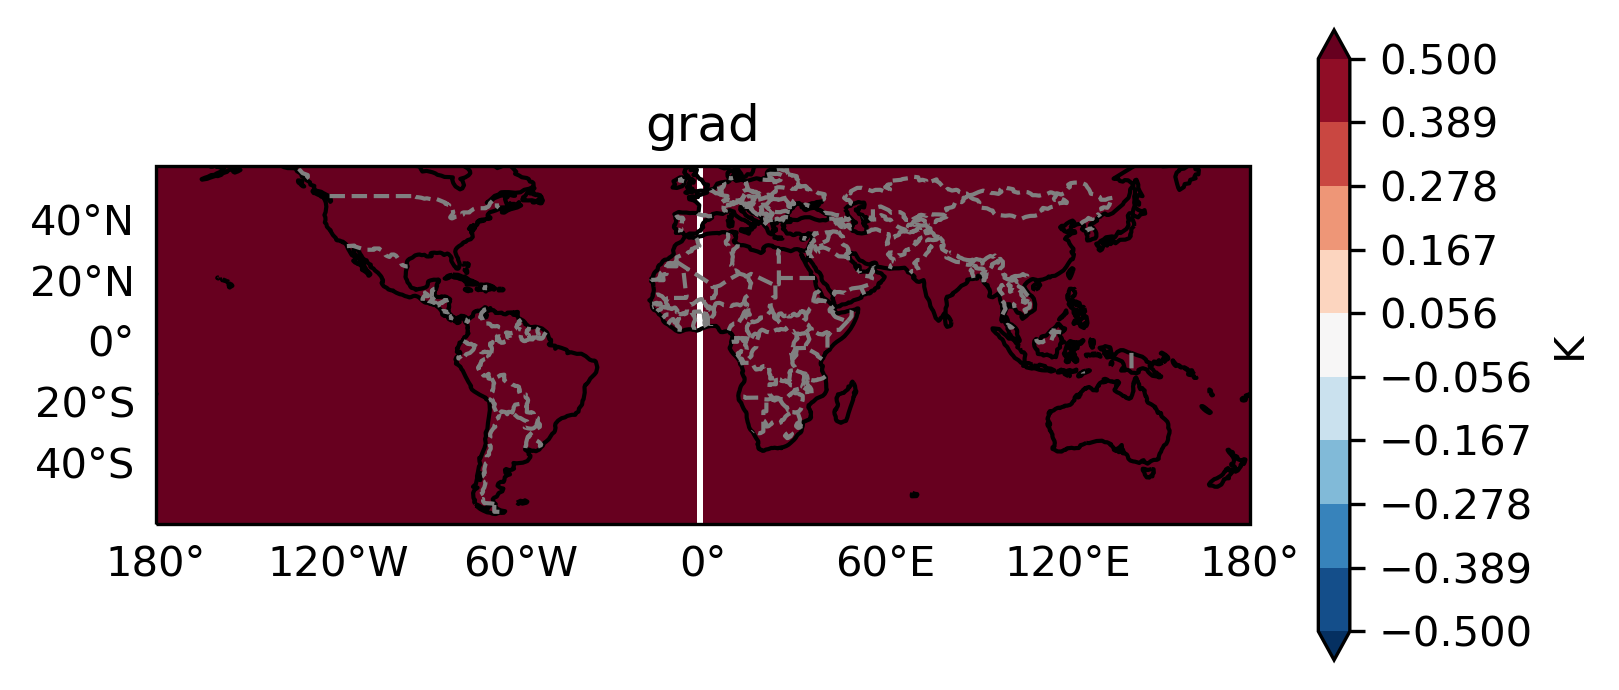

In [180]:
f = plt.figure(figsize=(20,6), dpi=300)

ax = f.add_subplot(2,3,ids+1, projection=ccrs.PlateCarree())
draw_map(ax, np.abs(fut-hist), hist.lat, hist.lon, title='grad', levels=np.linspace(-0.5,0.5,10), clabel='K')

In [177]:
hist, fut, ahist, afut = get_var('tas', 'DJF')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defi

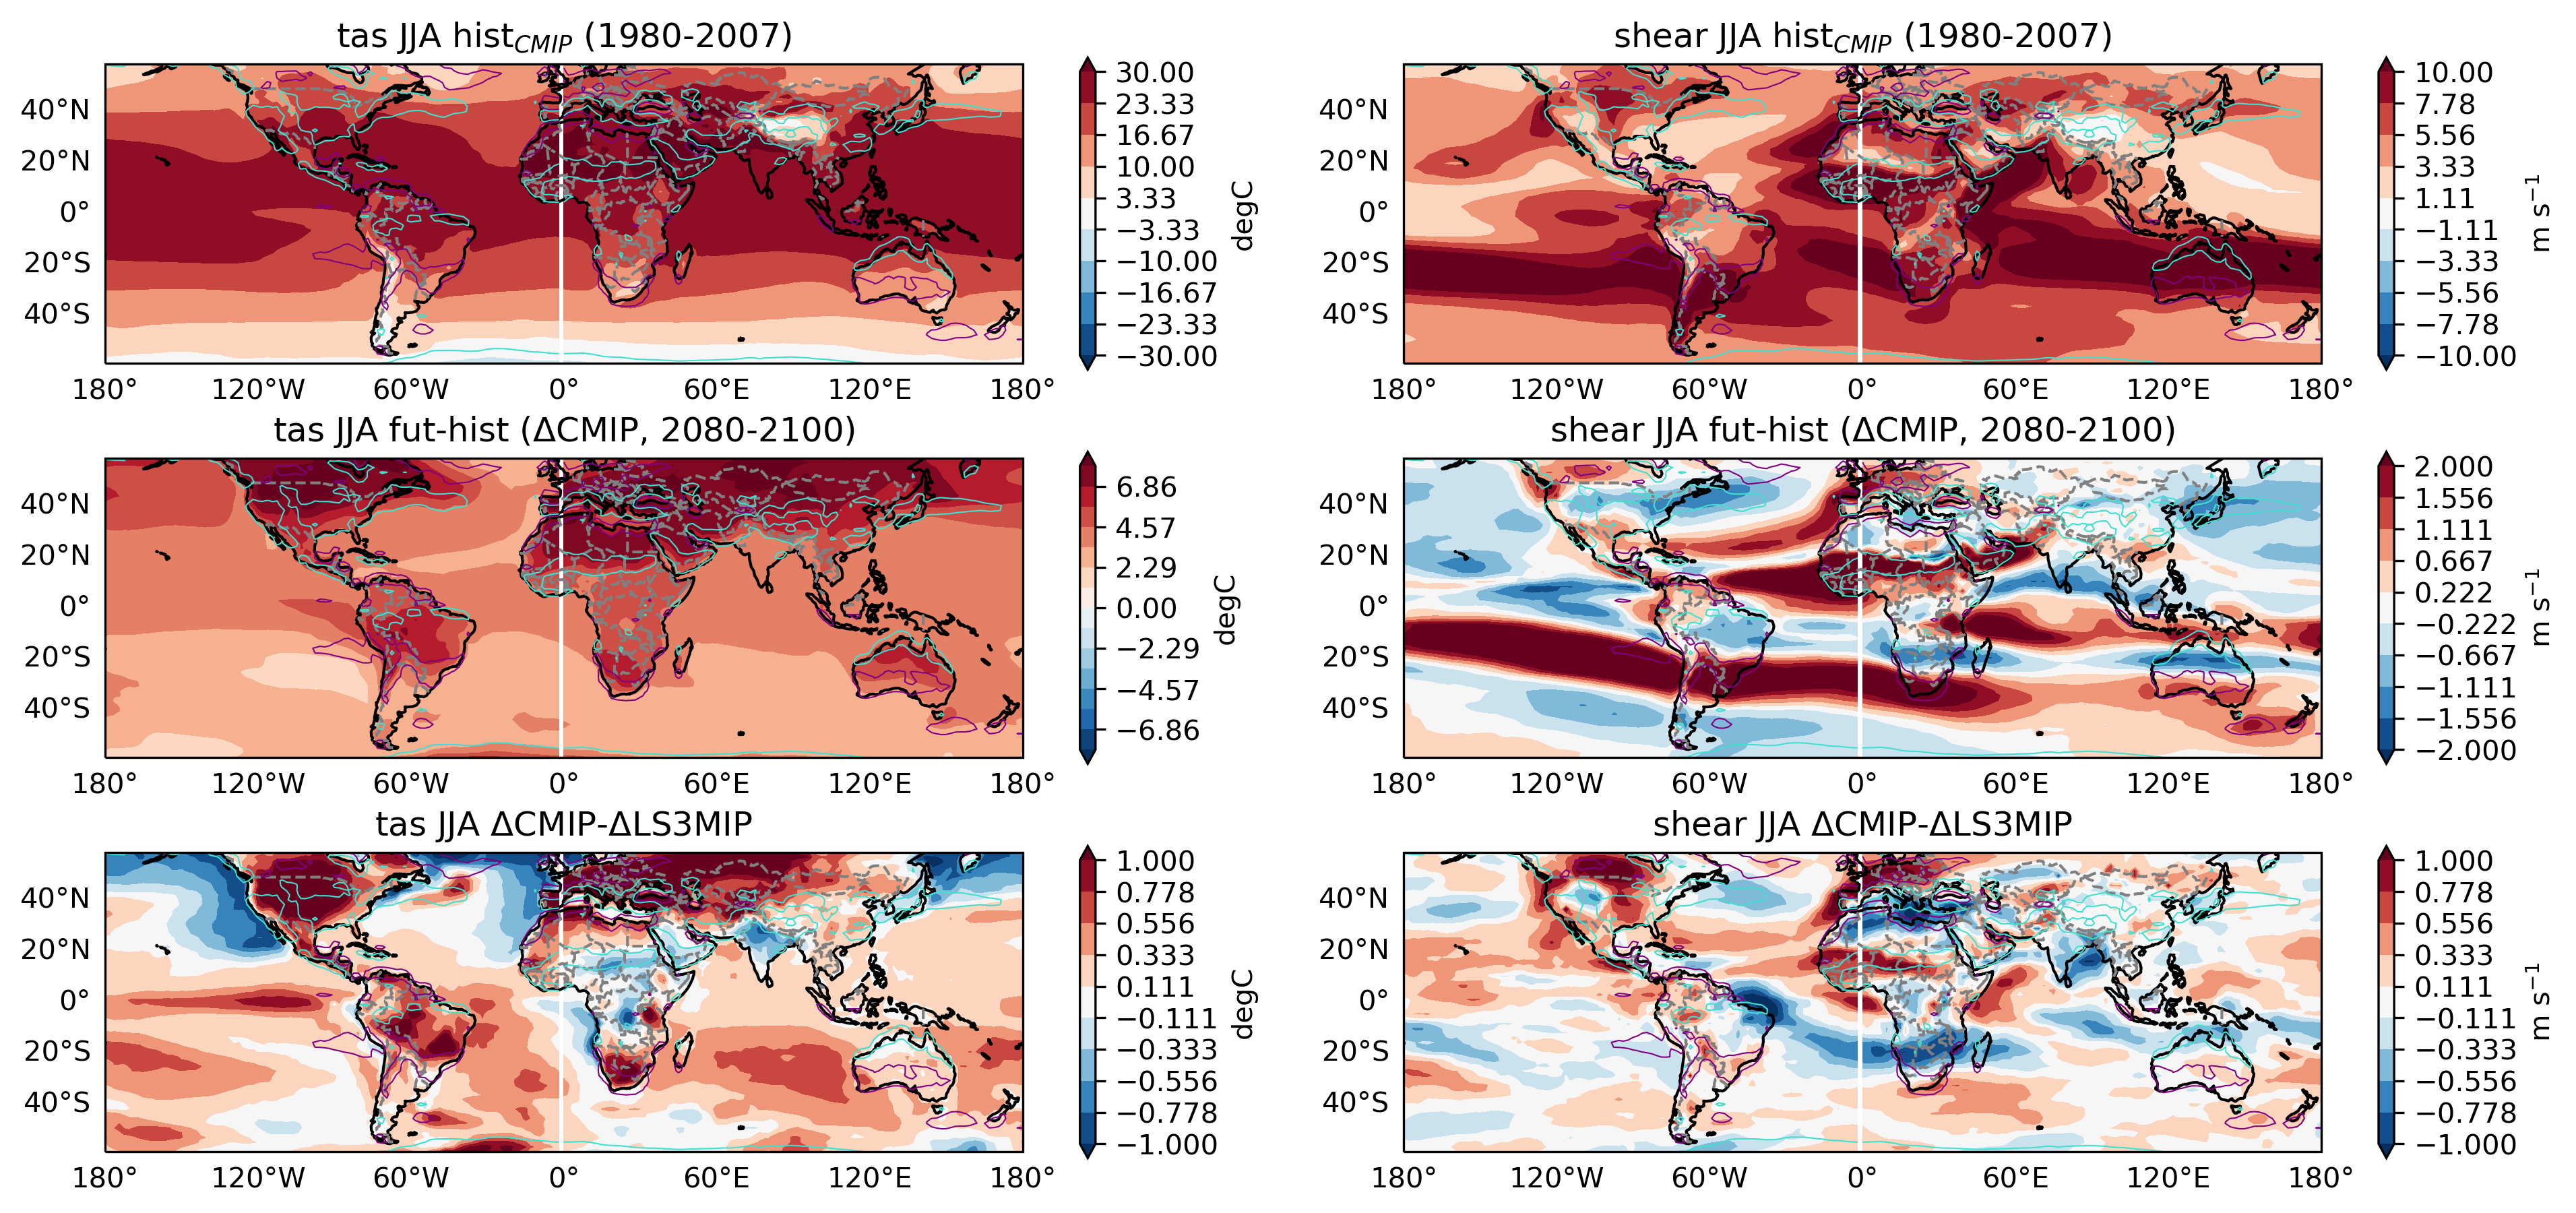

In [270]:
f = plt.figure(figsize=(13,6), dpi=300)

VAR1='tas'
mtag = 'JJA'
masking = ''
hist, fut, ahist, afut = get_var(VAR1, mtag)
orig = hist-273.15
diff = fut - hist
fulldiff = diff - (afut-ahist)

titles = [VAR1+' '+mtag+' hist$_{CMIP}$ (1980-2007)', VAR1+' '+mtag+' fut-hist ($\Delta$CMIP, 2080-2100)', VAR1+' '+mtag+' $\Delta$CMIP-$\Delta$LS3MIP']
color = ['RdBu_r', 'inferno', 'RdBu_r']

ghist, gfut, gahist, gafut = get_var('tgrad', mtag)
contour = {'data' : gfut-ghist, 'x': orig.lon, 'y' : orig.lat, 'levels' : [-10,0.35]}

idx = [1,3,5]
for ids,plot in enumerate([orig, diff, fulldiff]):
    ax = f.add_subplot(3,2,idx[ids], projection=ccrs.PlateCarree())
    draw_map(ax, plot, orig.lat, orig.lon, title=titles[ids], levels=t_levels[ids], clabel='degC', contour=contour) #np.percentile(k, np.arange(5,91,11)
    contours = ax.contour(orig.lon, orig.lat, (gfut-ghist)*-1, levels=[-10,0.35], colors='purple', linewidths=0.5)
    f.canvas.draw()


VAR2='shear'
hist, fut, ahist, afut = get_var(VAR2, mtag)
orig = hist
diff = fut - hist
fulldiff = diff - (afut-ahist)

titles = [VAR2+' '+mtag+' hist$_{CMIP}$ (1980-2007)', VAR2+' '+mtag+' fut-hist ($\Delta$CMIP, 2080-2100)', VAR2+' '+mtag+' $\Delta$CMIP-$\Delta$LS3MIP']

idx = [2,4,6]
for ids,plot in enumerate([orig, diff, fulldiff]):
    ax = f.add_subplot(3,2,idx[ids], projection=ccrs.PlateCarree())
    
    if (ids == 2) & (masking != ''):
        mask = np.sign(fulldiff) == np.sign(diff)
        plot = plot.where(mask)
    
    draw_map(ax, plot, orig.lat, orig.lon, title=titles[ids], levels=w_levels[ids], clabel=r'm s$^{-1}$', contour=contour) #np.percentile(k, np.arange(5,91,11)
    contours = ax.contour(orig.lon, orig.lat, (gfut-ghist)*-1, levels=[-10,0.35], colors='purple', linewidths=0.5)
    f.canvas.draw()
    
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/'+VAR1+'_'+VAR2+'_'+mtag+masking+'.pdf')

Doing IPSL-CM6A-LR


/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defi

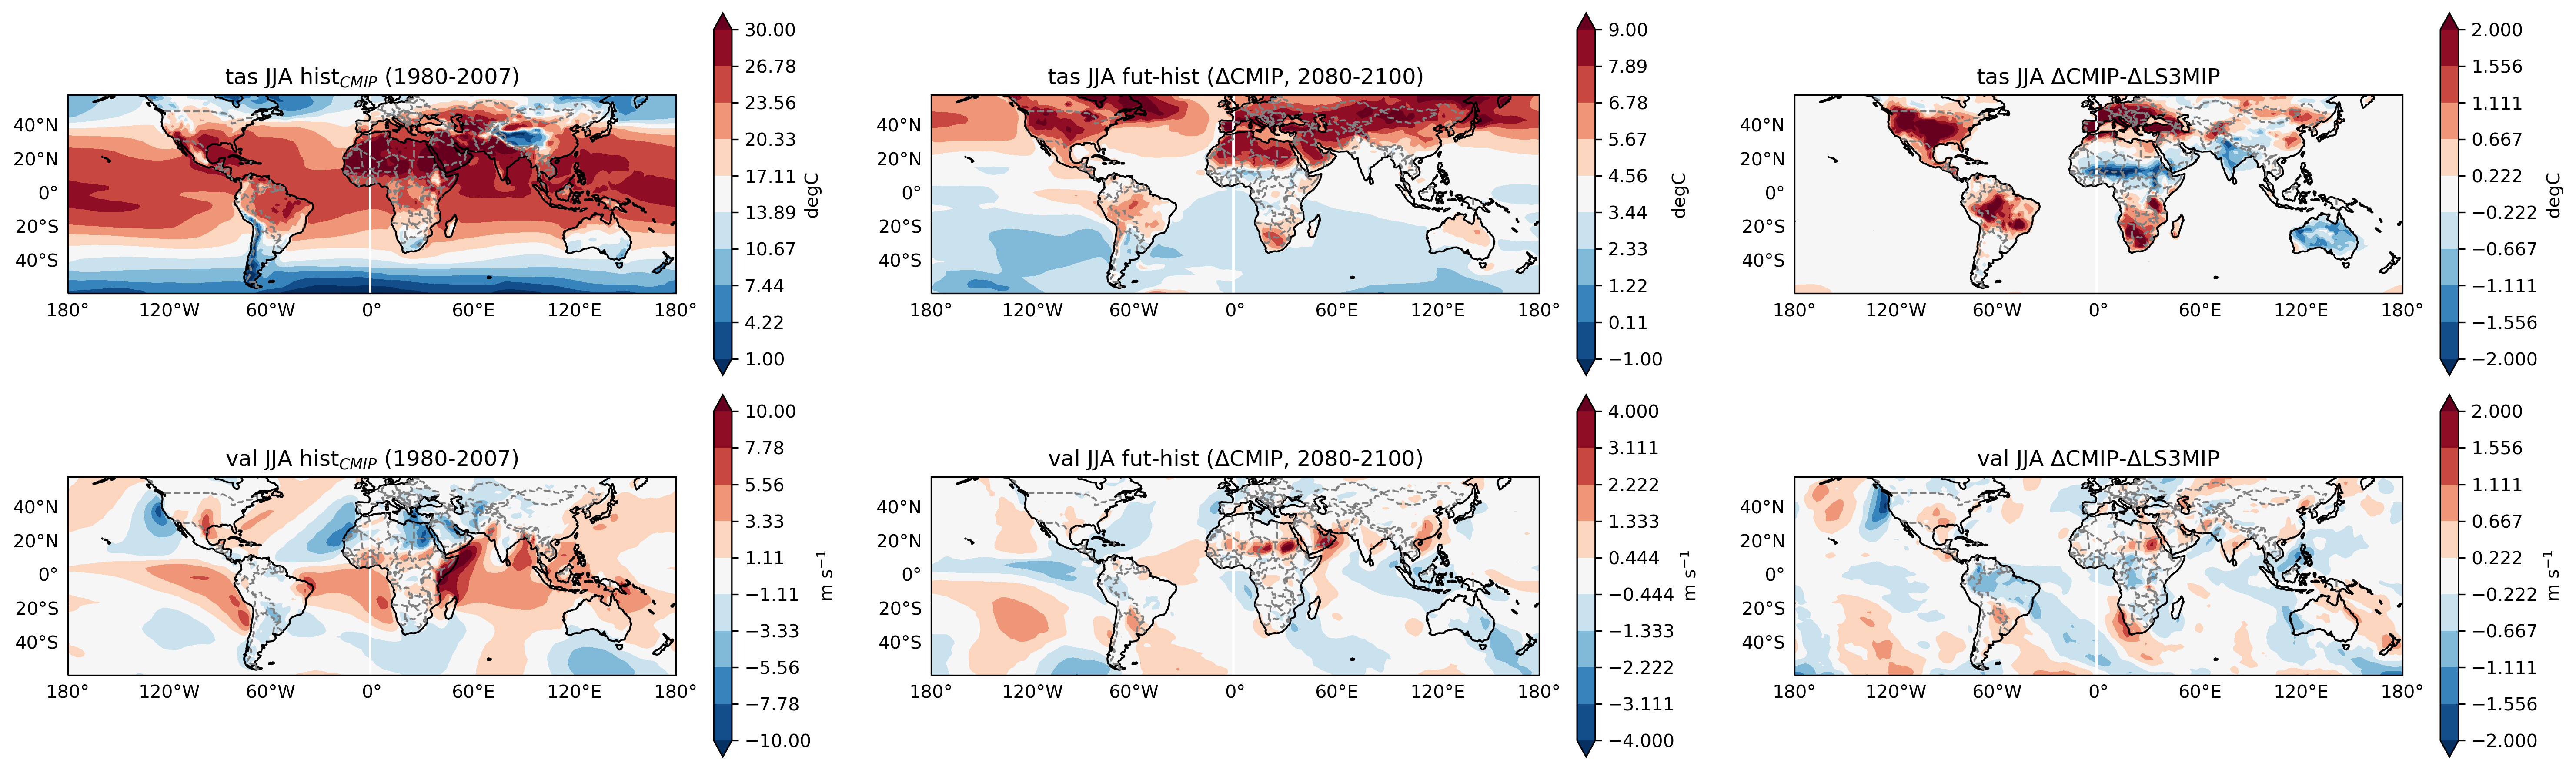

In [263]:
############# PLOTS PER MODEL
######################################

f = plt.figure(figsize=(20,6), dpi=300)

VAR1='tas'
mtag = 'JJA'
model_id = 2
print('Doing', cmip_models[model_id])
hist, fut, ahist, afut = get_var_model(VAR1, mtag, model_id)
orig = hist-273.15
diff = fut - hist
fulldiff = diff - (afut-ahist)
levelss = [np.linspace(1,30,10), np.linspace(-1,9,10), np.linspace(-2,2,10)]
titles = [VAR1+' '+mtag+' hist$_{CMIP}$ (1980-2007)', VAR1+' '+mtag+' fut-hist ($\Delta$CMIP, 2080-2100)', VAR1+' '+mtag+' $\Delta$CMIP-$\Delta$LS3MIP']

for ids,plot in enumerate([orig, diff, fulldiff]):
    ax = f.add_subplot(2,3,ids+1, projection=ccrs.PlateCarree())
    draw_map(ax, plot, orig.lat, orig.lon, title=titles[ids], levels=levelss[ids], clabel='degC') #np.percentile(k, np.arange(5,91,11)
    f.canvas.draw()


VAR2='val'
mtag = 'JJA'
hist, fut, ahist, afut = get_var_model(VAR2, mtag, model_id)
orig = hist
diff = fut - hist
fulldiff = diff - (afut-ahist)
levelss = [np.linspace(-10,10,10), np.linspace(-4,4,10), np.linspace(-2,2,10)]
titles = [VAR2+' '+mtag+' hist$_{CMIP}$ (1980-2007)', VAR2+' '+mtag+' fut-hist ($\Delta$CMIP, 2080-2100)', VAR2+' '+mtag+' $\Delta$CMIP-$\Delta$LS3MIP']

for ids,plot in enumerate([orig, diff, fulldiff]):
    ax = f.add_subplot(2,3,ids+4, projection=ccrs.PlateCarree())
    draw_map(ax, plot, orig.lat, orig.lon, title=titles[ids], levels=levelss[ids], clabel=r'm s$^{-1}$') #np.percentile(k, np.arange(5,91,11)
    f.canvas.draw()
    
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/'+model+'_'+VAR1+'_'+VAR2+'_'+mtag+'.pdf')

In [241]:
era5f_pl = xr.open_mfdataset('/media/ck/LStorage/global_water/other/ERA5_global_0.7/monthly/pressure_levels/*.nc')
era5f_pl = u_darrays.flip_lat(era5f_pl)
era_uh = era5f_pl['u'].sel(level=650).groupby('time.season').mean('time').load()
era_ul = era5f_pl['u'].sel(level=925).groupby('time.season').mean('time').load()
era_vh = era5f_pl['v'].sel(level=650).groupby('time.season').mean('time').load()
era_vl = era5f_pl['v'].sel(level=925).groupby('time.season').mean('time').load()

era_ushear = era_uh-era_ul
era_vshear = era_vh-era_vl
era_shear = np.sqrt(era_ushear**2+era_vshear**2)

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


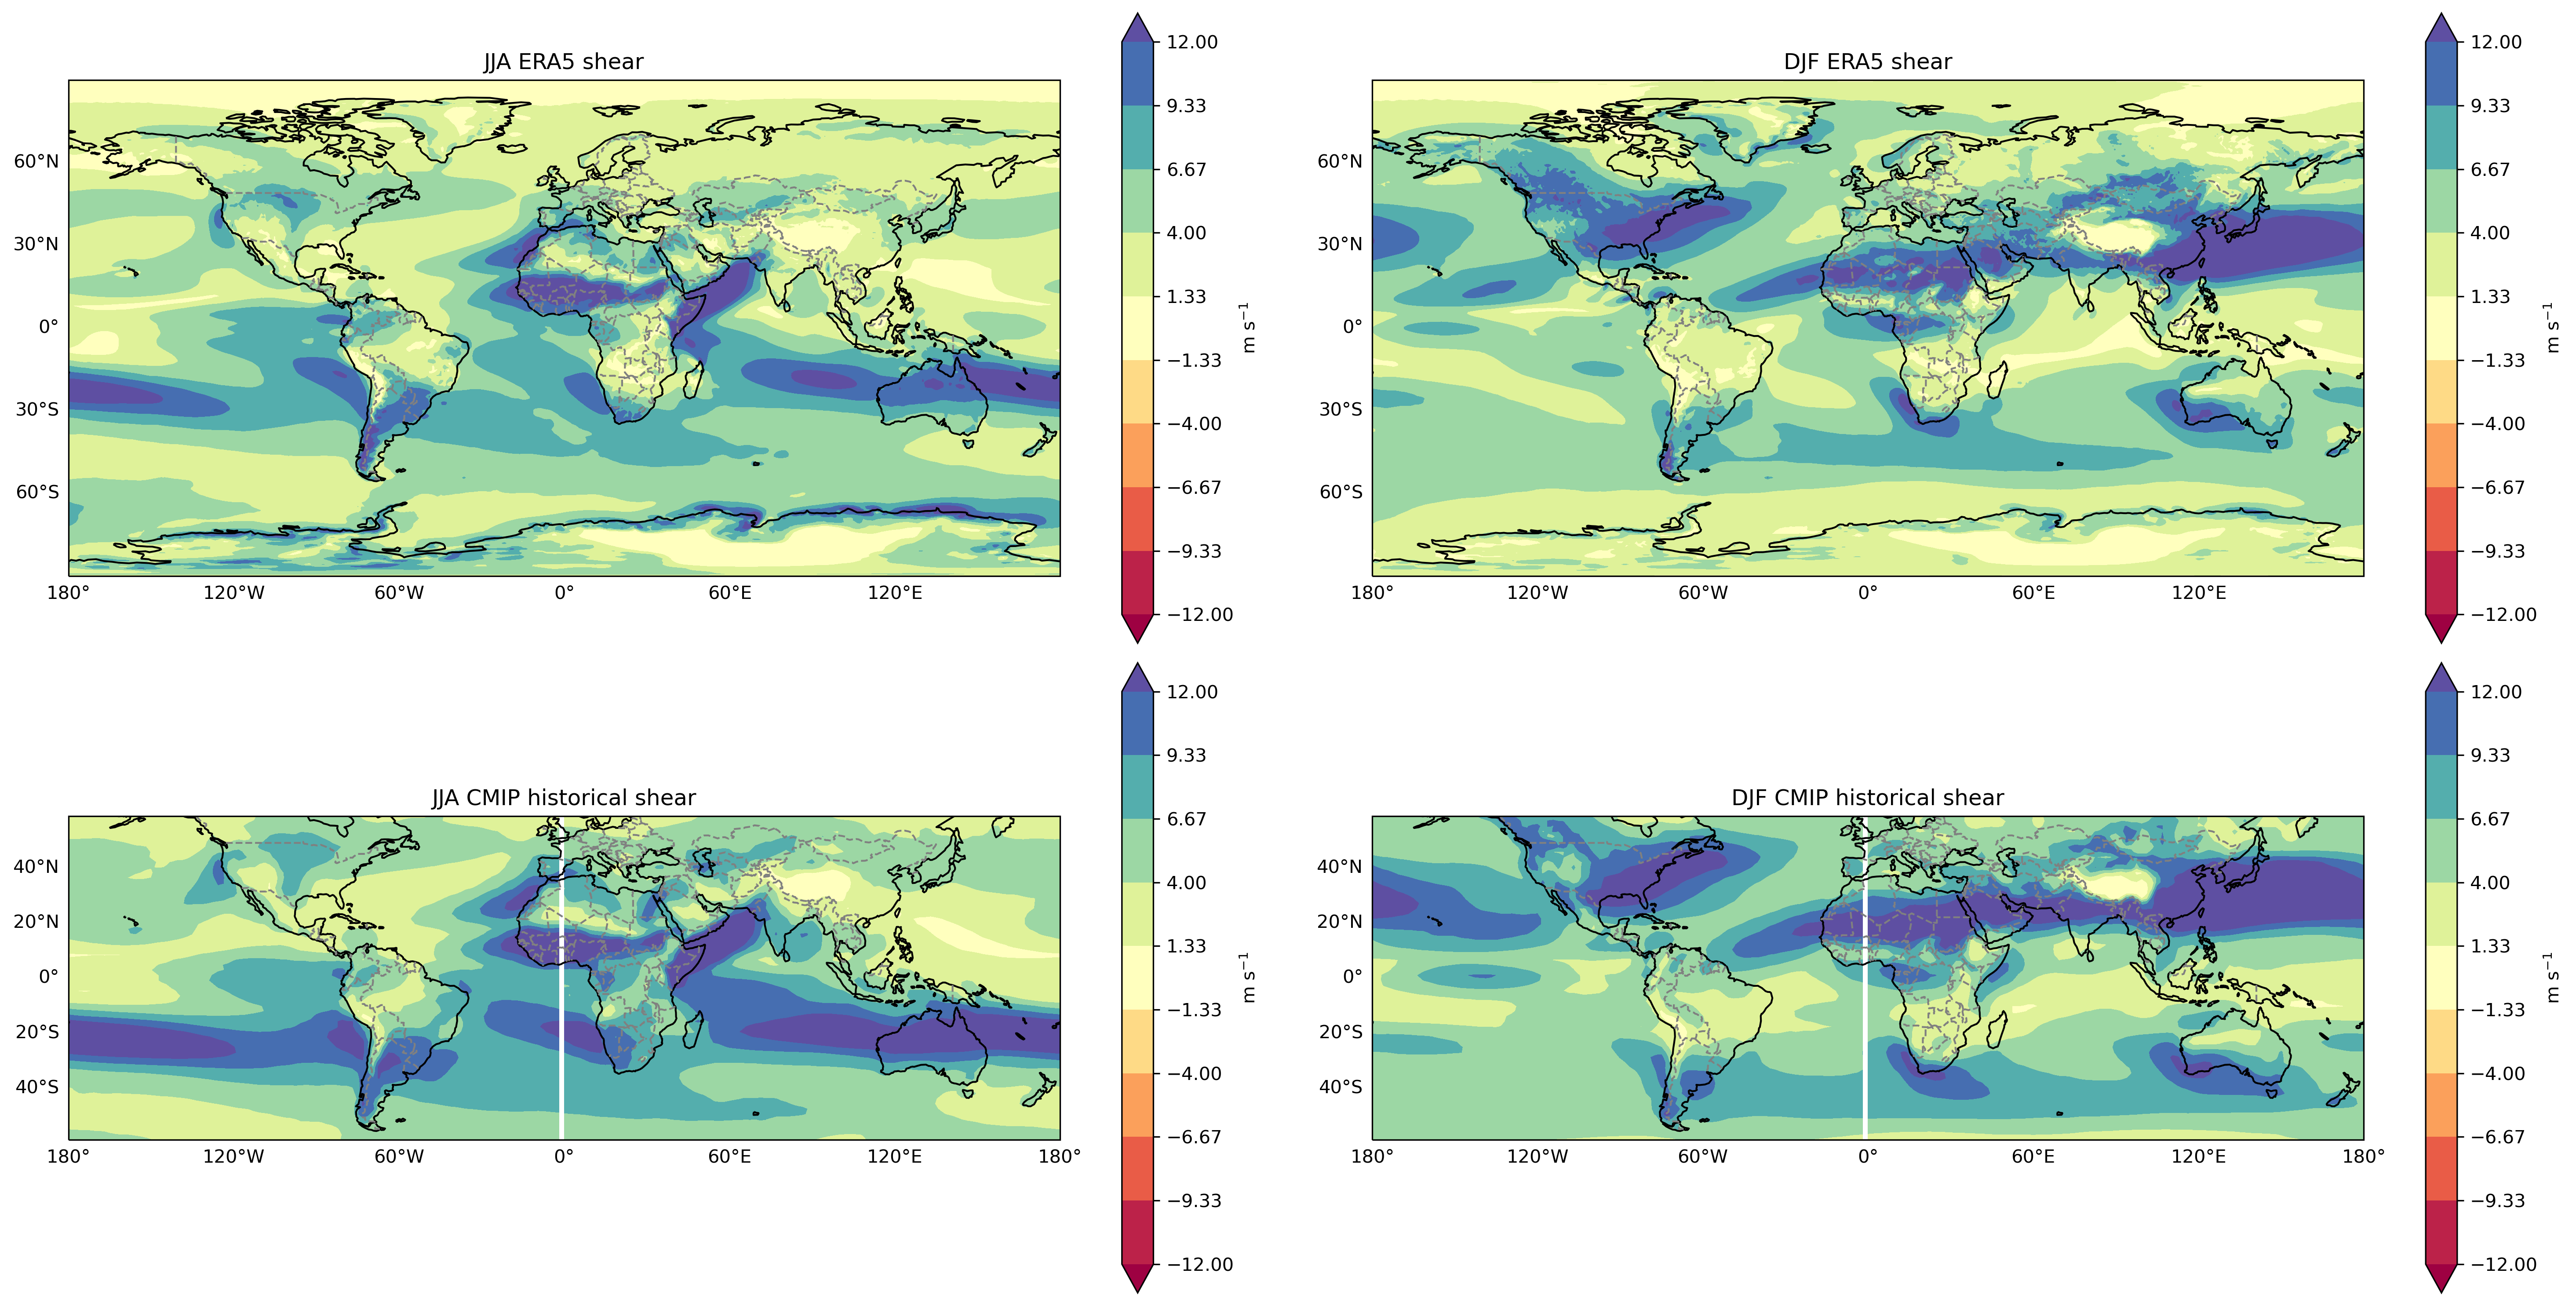

In [216]:
f = plt.figure(figsize=(20,10), dpi=300)

mtag = 'JJA'
ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax, era_shear.sel(season=mtag), era_shear.latitude, era_shear.longitude, title=mtag+' ERA5 shear', levels=np.linspace(-12,12,10), clabel=r'm s$^{-1}$', cmap='Spectral') #np.percentile(k, np.arange(5,91,11)

mtag = 'DJF'
ax = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax, era_shear.sel(season=mtag), era_shear.latitude, era_shear.longitude, title=mtag+ ' ERA5 shear', levels=np.linspace(-12,12,10), clabel=r'm s$^{-1}$', cmap='Spectral') #np.percentile(k, np.arange(5,91,11)


VAR='shear'
mtag = 'JJA'
hist, fut, ahist, afut = get_var(VAR, mtag)
orig = hist
ax = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax, orig, orig.lat, orig.lon, title=mtag+ ' CMIP historical shear', levels=np.linspace(-12,12,10), clabel=r'm s$^{-1}$', cmap='Spectral')

VAR='shear'
mtag = 'DJF'
hist, fut, ahist, afut = get_var(VAR, mtag)
orig = hist
ax = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax, orig, orig.lat, orig.lon, title=mtag+ ' CMIP historical shear', levels=np.linspace(-12,12,10), clabel=r'm s$^{-1}$', cmap='Spectral')



plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/CMIP6vsERA5_windShear.pdf')